In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Methods

# 1. Concurrent

In [29]:
toml_df_concurrent = pd.read_csv('~/results/toml_methods_concurrent.csv')
etcd_df_concurrent = pd.read_csv('~/results/etcd_methods_concurrent.csv')
chp_df_concurrent = pd.read_csv('~/results/chp_methods_concurrent.csv')

frames = [toml_df_concurrent, etcd_df_concurrent, chp_df_concurrent]
proxies_df_concurrent = pd.concat(frames)

In [30]:
def plot_proxy_method_perf(
    plot_proxy_method_perf, df, proxy, method, run_type, time_type=None, color=None
):
    q = f'proxy == "{proxy}" and method == "{method}"'
    
    if not time_type:
        proxy_method_df = df.query(q)[['route_idx', 'proxy', 'cpu_time', 'real_time']]
    else:
        proxy_method_df = df.query(q)[['route_idx', 'proxy', time_type]]
        
    grouped = proxy_method_df.groupby(['route_idx'])
    errors = grouped.std()
    means = grouped.mean()
    
    if method == "delete" and run_type == "sequential":
        means.index = np.flip(means.index)

    means.plot(
        kind="line", yerr=errors, capsize=4, ax=ax,
        figsize=(20, 10), marker="o", markersize=10,
        title=proxy + " " + method + " " + run_type
    )


## add_route

* There were **500** routes to be added to the proxy's routing table.

* All 500 calls to `add_route(route_idx)` were run **concurrently**, taking advantage of the async I/O operations of `add_route`.

* The plots show the mean of both the **wall time** and the **cpu time** (in seconds) measured per `add_route` function call and computed by running the test (adding all 500 routes) 4 times. The difference between wall time and cpu time is the I/O time.

* TraefikEtcdProxy waits for the route to be added both to etcd and to traefik's routing table

* Traefik's **providersThrottleDuration** was 2s, meaning that traefik re-aplied the configuration after 2s from an etcd event. In a concurrent scenario, this means that at the time traefik re-aplied the configuration there were more than one routes added to etcd/file and the `add_route` function calls asociated with this routes finished more or less at the same time. 

Text(0, 0.5, 'Time (s)')

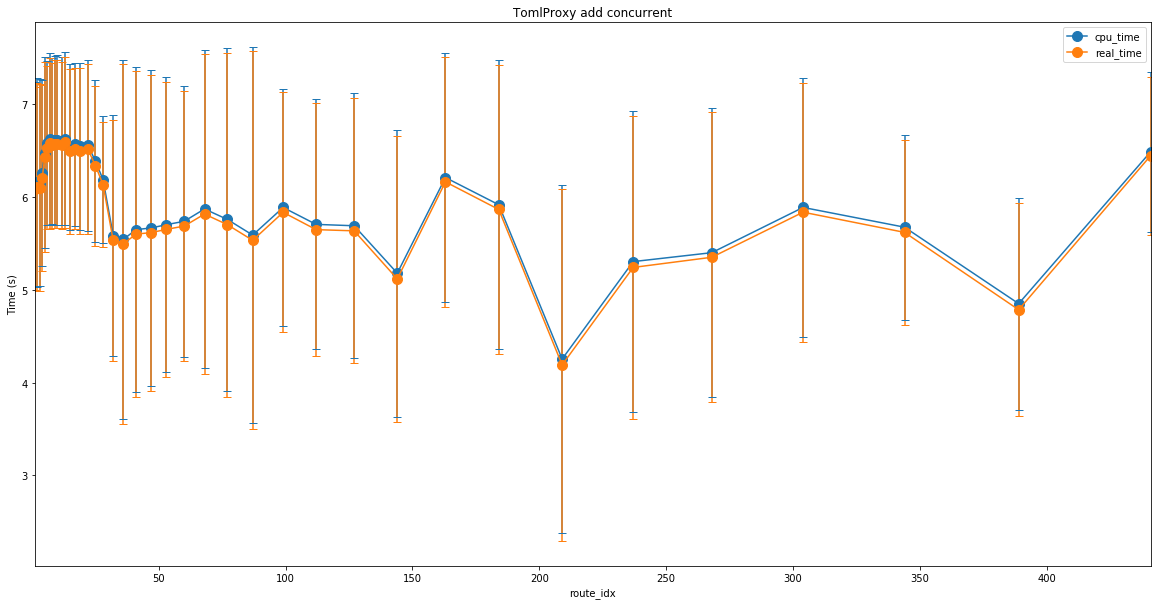

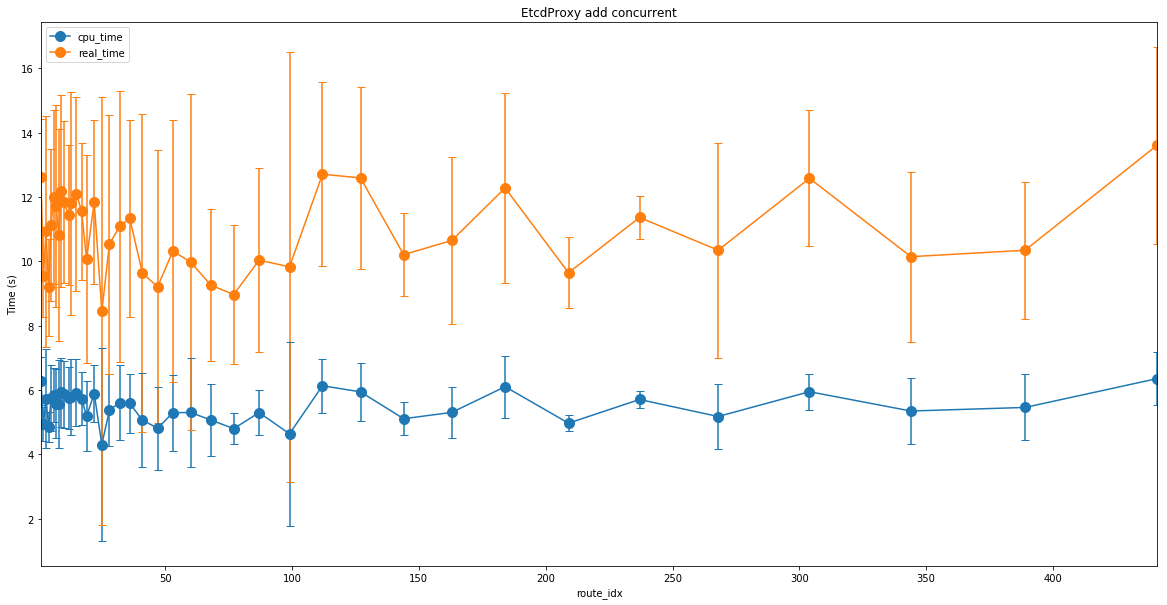

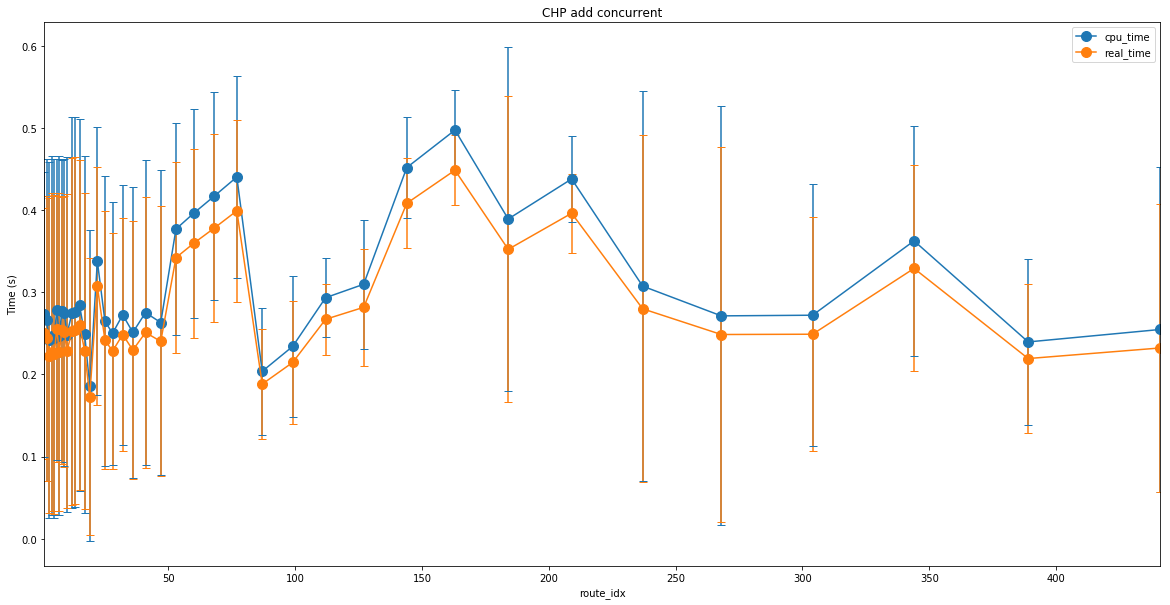

In [31]:
fig, ax = plt.subplots()
plot_proxy_method_perf(ax, proxies_df_concurrent, "TomlProxy", "add", "concurrent")
plt.gca().set_ylabel("Time (s)")

fig, ax = plt.subplots()
plot_proxy_method_perf(ax, proxies_df_concurrent, "EtcdProxy", "add", "concurrent")
plt.gca().set_ylabel("Time (s)")

fig, ax = plt.subplots()
plot_proxy_method_perf(ax, proxies_df_concurrent, "CHP", "add", "concurrent")
plt.gca().set_ylabel("Time (s)")

## delete_route

* There were **500** routes to be deleted from the proxy's routing table.

* All 500 calls to `delete_route(route_idx)` were run concurrently, taking advantage of the async I/O operations of `delete_route`.

* The plots show the mean of both the **wall time** and the **cpu time** (in seconds) measured per `delete_route` function call and computed by running the test (deleting all 500 routes) 4 times.

* Traefik's **providersThrottleDuration** was 2s.

* **TraefikEtcdProxy** only waits for the routes to be deleted from etcd. The route will be deleted from traefik's routing table after `providersThrottleDuration` elapses.

Text(0, 0.5, 'Time (s)')

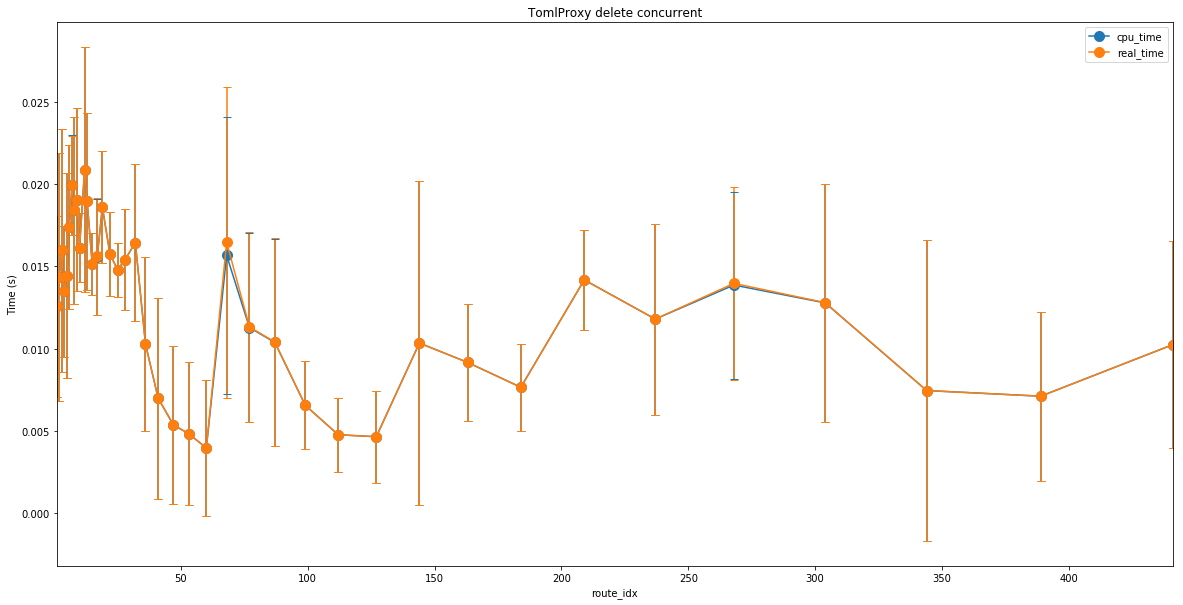

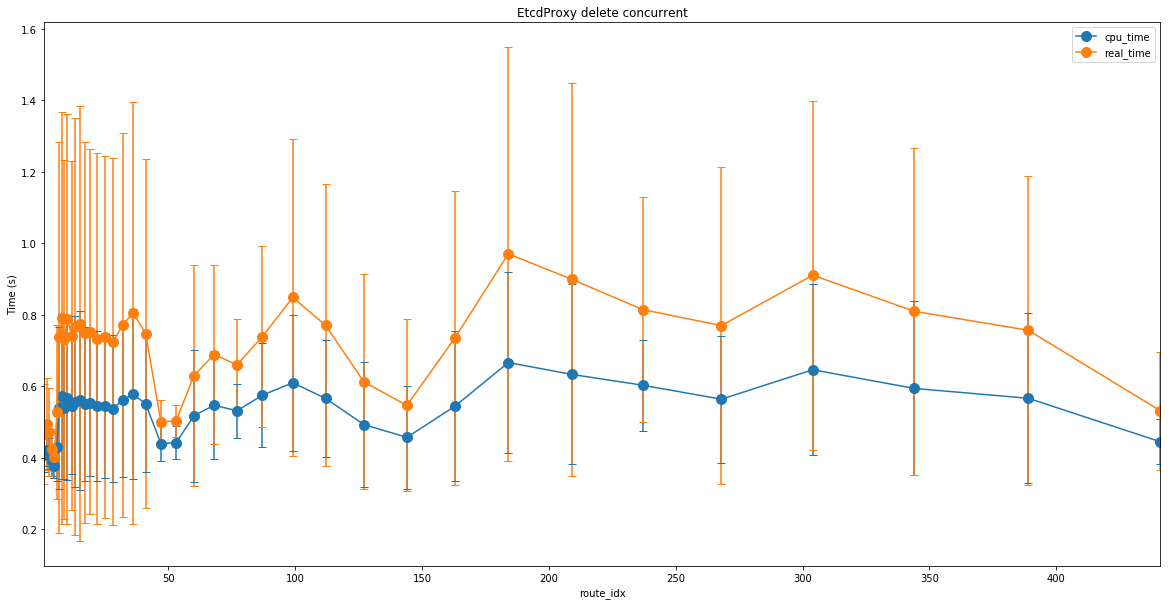

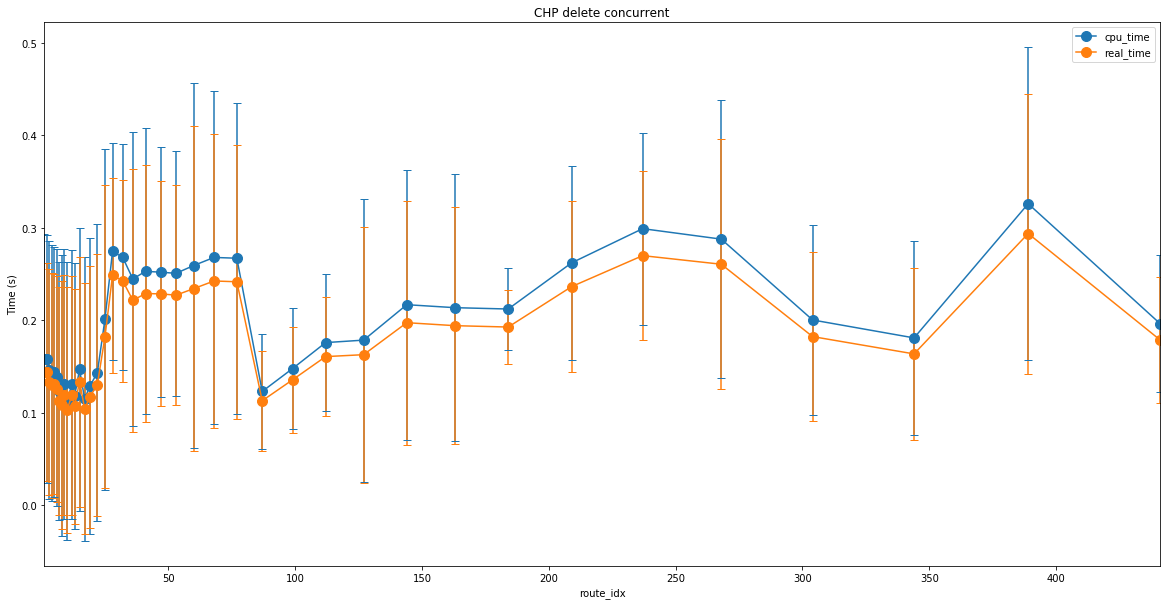

In [32]:
fig, ax = plt.subplots()
plot_proxy_method_perf(ax, proxies_df_concurrent, "TomlProxy", "delete", "concurrent")
plt.gca().set_ylabel("Time (s)")

fig, ax = plt.subplots()
plot_proxy_method_perf(ax, proxies_df_concurrent, "EtcdProxy", "delete", "concurrent")
plt.gca().set_ylabel("Time (s)")

fig, ax = plt.subplots()
plot_proxy_method_perf(ax, proxies_df_concurrent, "CHP", "delete", "concurrent")
plt.gca().set_ylabel("Time (s)")

## get_all_routes

* There were **500** routes that were retrieved **500** times from the proxy's routing table.

* All 500 calls to `get_all_routes` were run **concurrently**, taking advantage of the async I/O operations of `get_all_routes`.

* The plots show the mean of both the **wall time** and the **cpu time** (in seconds) measured per `get_all_routes` function call and computed by running the test 4 times.

* Traefik's **providersThrottleDuration** was 2s.

Text(0, 0.5, 'Time (s)')

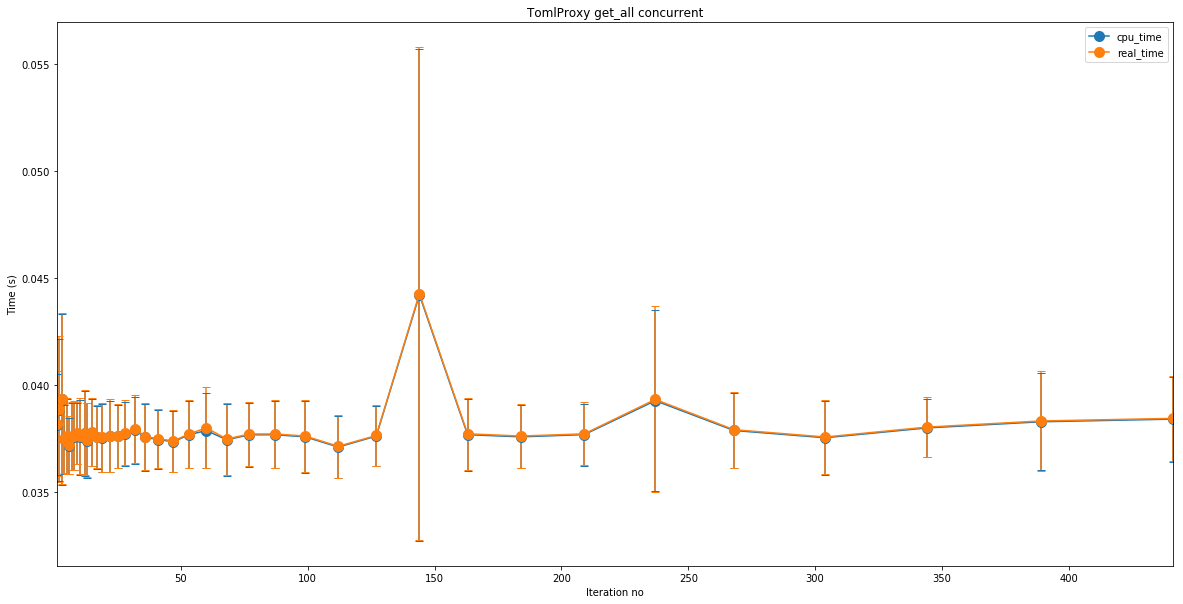

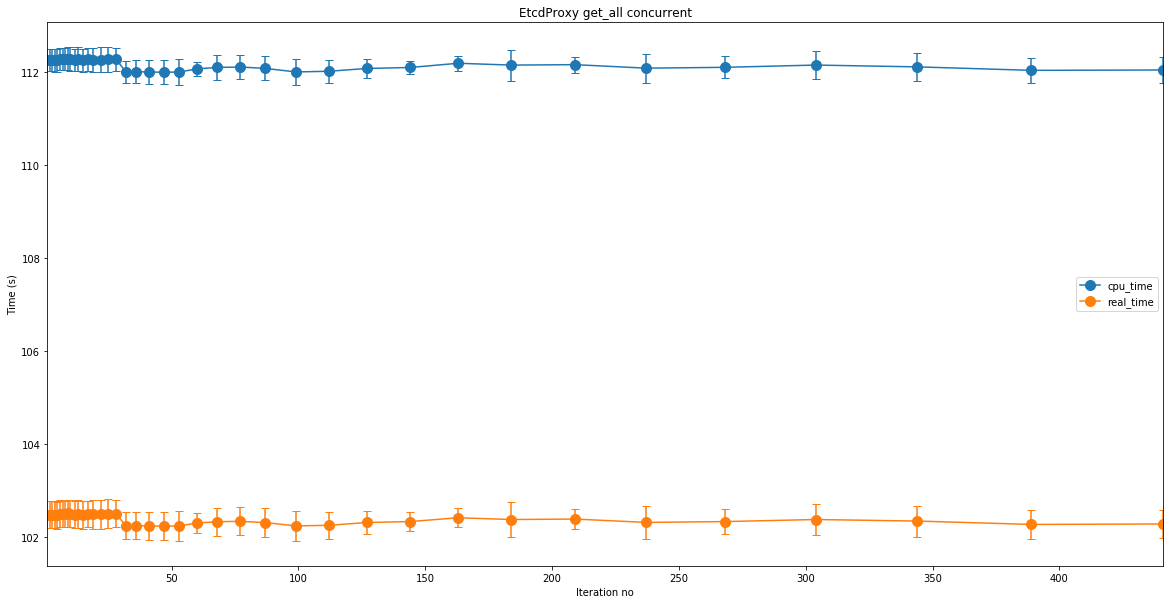

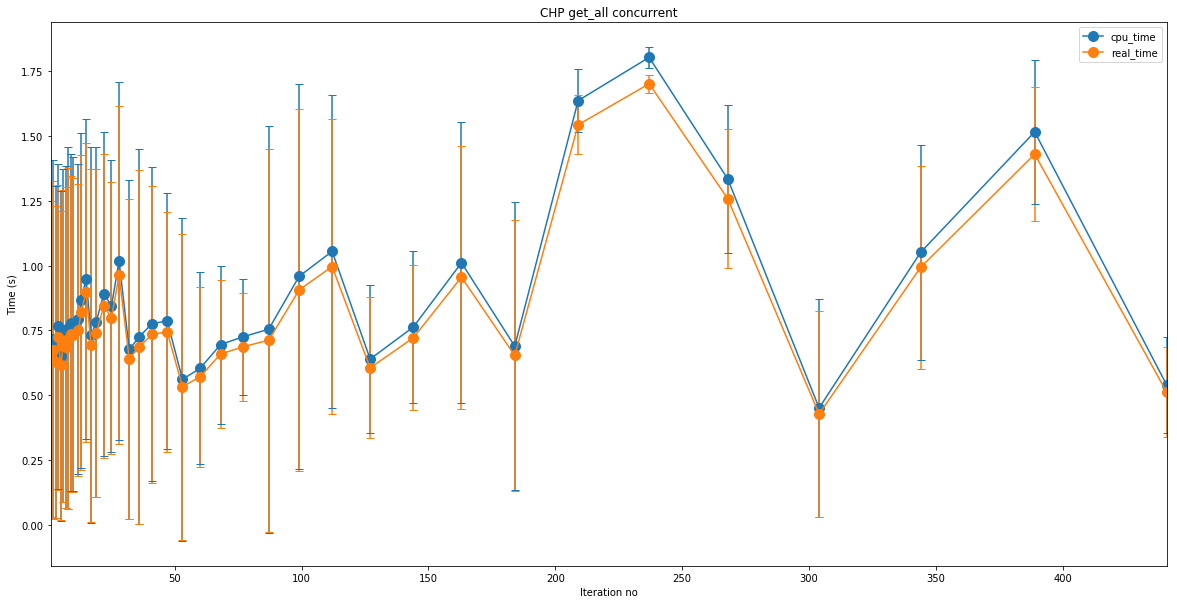

In [33]:
fig, ax = plt.subplots()
plot_proxy_method_perf(ax, proxies_df_concurrent, "TomlProxy", "get_all", "concurrent")
plt.gca().set_xlabel("Iteration no")
plt.gca().set_ylabel("Time (s)")

fig, ax = plt.subplots()
plot_proxy_method_perf(ax, proxies_df_concurrent, "EtcdProxy", "get_all", "concurrent")
plt.gca().set_xlabel("Iteration no")
plt.gca().set_ylabel("Time (s)")

fig, ax = plt.subplots()
plot_proxy_method_perf(ax, proxies_df_concurrent, "CHP", "get_all", "concurrent")
plt.gca().set_xlabel("Iteration no")
plt.gca().set_ylabel("Time (s)")

# 2. Sequential

In [34]:
toml_df_seq = pd.read_csv('~/results/toml_methods_sequential.csv')
etcd_df_seq = pd.read_csv('~/results/etcd_methods_sequential.csv')
chp_df_seq = pd.read_csv('~/results/chp_methods_sequential.csv')

frames = [toml_df_seq, etcd_df_seq, chp_df_seq]
proxies_df_seq = pd.concat(frames)

## add_route

* There were **500** routes to be added to the proxy's routing table.

* All 500 calls to `add_route(route_idx)` were run **sequentially**. 

* The plots show the **wall time** and the **cpu time** (in seconds) measured per `add_route` function call. The difference between wall time and cpu time is the I/O time.

* An `add_route` call blocks until the route is added both to etcd and to traefik's routing table.

* Traefik's **providersThrottleDuration was 0s**, meaning that traefik re-aplied the configuration immediatly after the route was added to etcd/file. In this sequential scenario, this means that at the time traefik re-aplied the configuration there was only one new route added to etcd/file.

**Note 1**: If route_index = 20, this means that the route number 20 was added to a routing table that already had 19 routes.

**Note 2**: The time to add a route increases linearly with the number of routes because every time a new route is added to etcd, traefik:
   * gets all the entries from etcd
   * for each (frontend, backend) pair associated with an entry traefik queries the etcd store for all the keys associated with a frontend/backend configuration option (tens of keys). 

Text(0, 0.5, 'Time (s)')

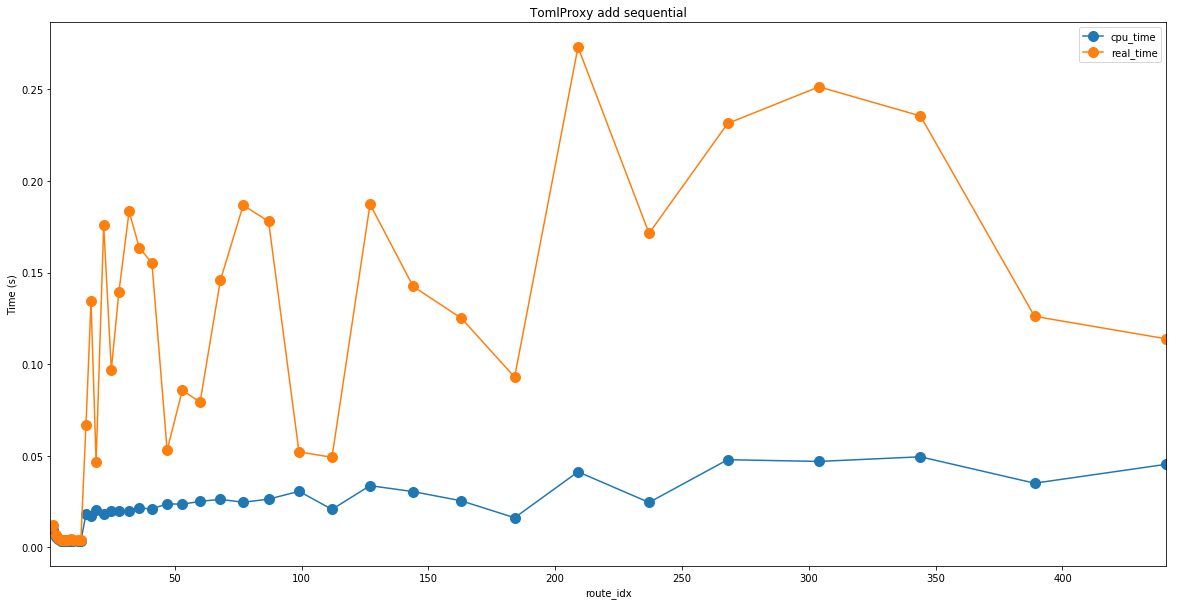

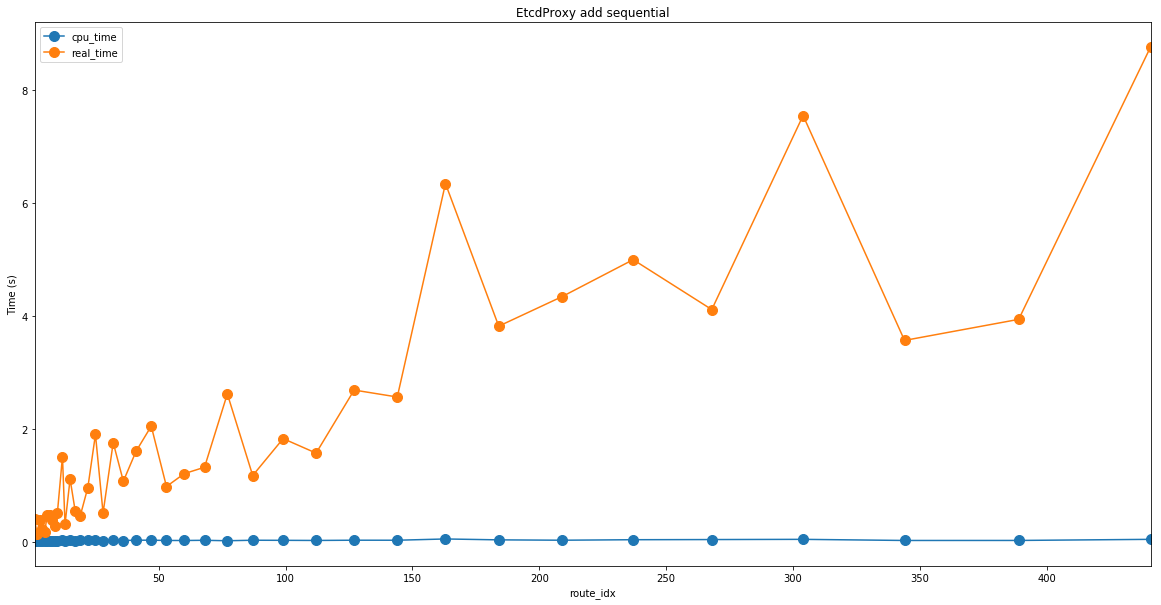

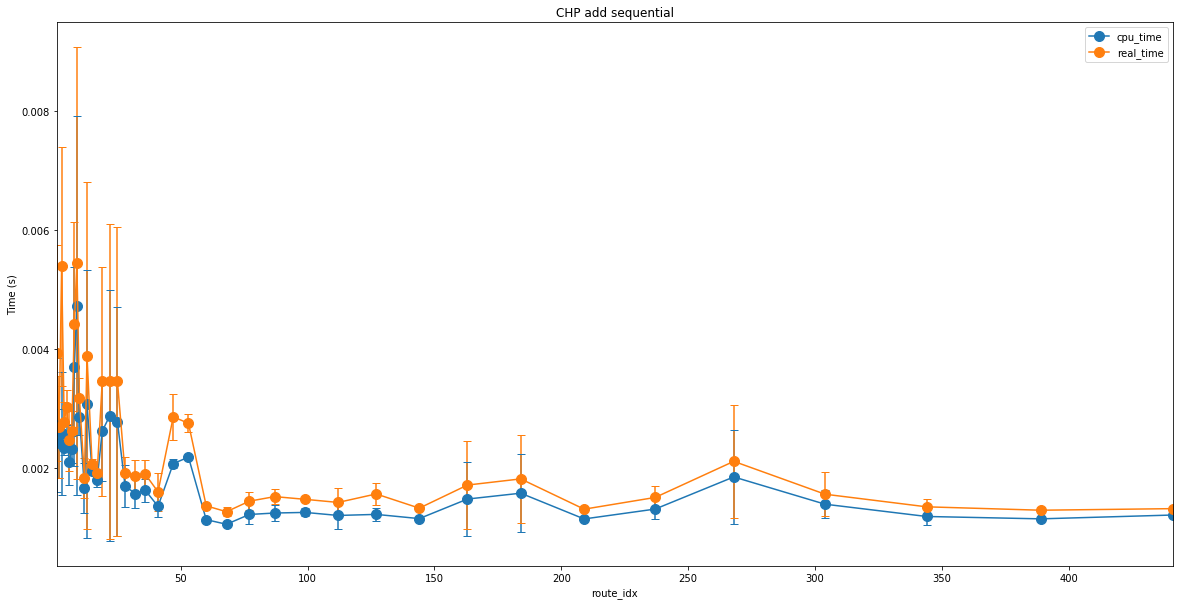

In [35]:
fig, ax = plt.subplots()
plot_proxy_method_perf(ax, proxies_df_seq, "TomlProxy", "add", "sequential")
plt.gca().set_ylabel("Time (s)")

fig, ax = plt.subplots()
plot_proxy_method_perf(ax, proxies_df_seq, "EtcdProxy", "add", "sequential")
plt.gca().set_ylabel("Time (s)")

fig, ax = plt.subplots()
plot_proxy_method_perf(ax, proxies_df_seq, "CHP", "add", "sequential")
plt.gca().set_ylabel("Time (s)")

## delete_route

* There were **500** routes to be deleted from the proxy's routing table.

* All 500 calls to `delete_route(route_idx)` were run **sequentially**. 

* The plots show the **wall time** and the **cpu time** (in seconds) measured per `delete_route` function call. The difference between wall time and cpu time is the I/O time.

* An `delete_route` call blocks until the route was deleted from etcd but not from traefik's routing table.

* Traefik's **providersThrottleDuration was 0s**, meaning that traefik re-aplied the configuration immediatly after the route was deleted from etcd/file.

**Note**: If route_index = 20, this means that the route number 20 was deleted from a routing table that had 21 routes. 

Text(0, 0.5, 'Time (s)')

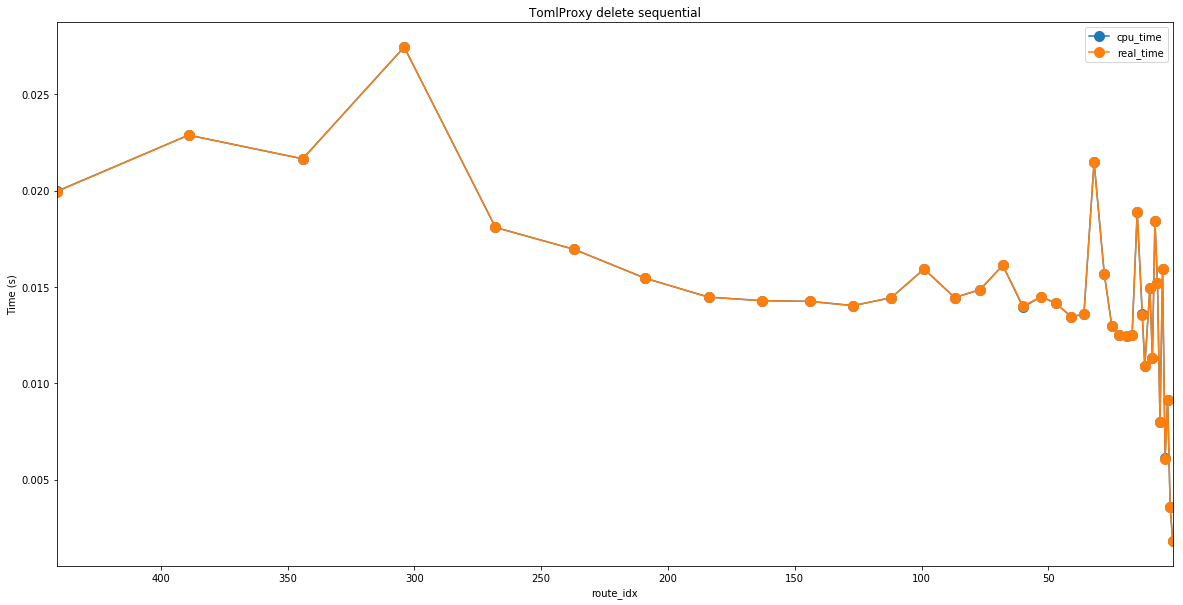

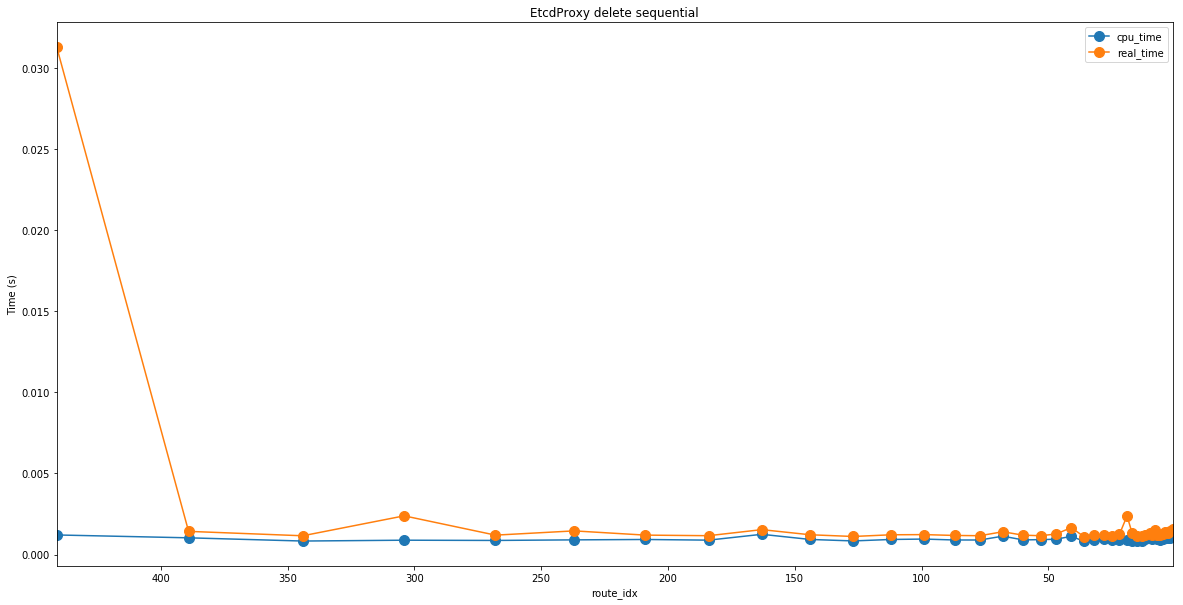

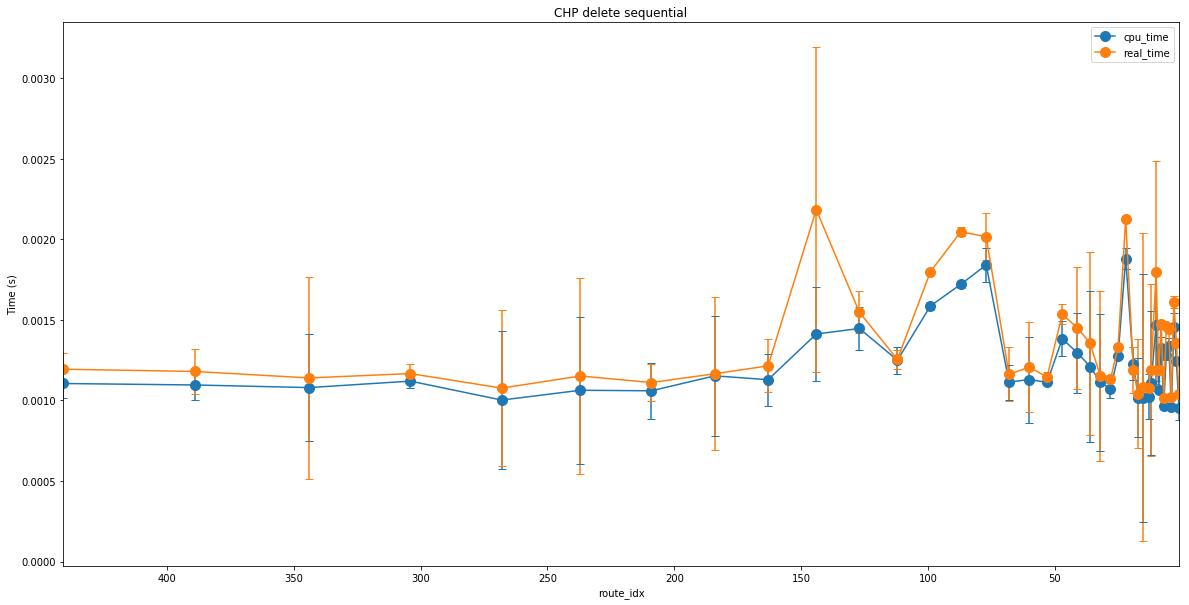

In [36]:
fig, ax = plt.subplots()
plot_proxy_method_perf(ax, proxies_df_seq, "TomlProxy", "delete", "sequential")
plt.gca().invert_xaxis()
plt.gca().set_ylabel("Time (s)")

fig, ax = plt.subplots()
plot_proxy_method_perf(ax, proxies_df_seq, "EtcdProxy", "delete", "sequential")
plt.gca().invert_xaxis()
plt.gca().set_ylabel("Time (s)")

fig, ax = plt.subplots()
plot_proxy_method_perf(ax, proxies_df_seq, "CHP", "delete", "sequential")
plt.gca().invert_xaxis()
plt.gca().set_ylabel("Time (s)")

## get_all_routes

Text(0, 0.5, 'Time (s)')

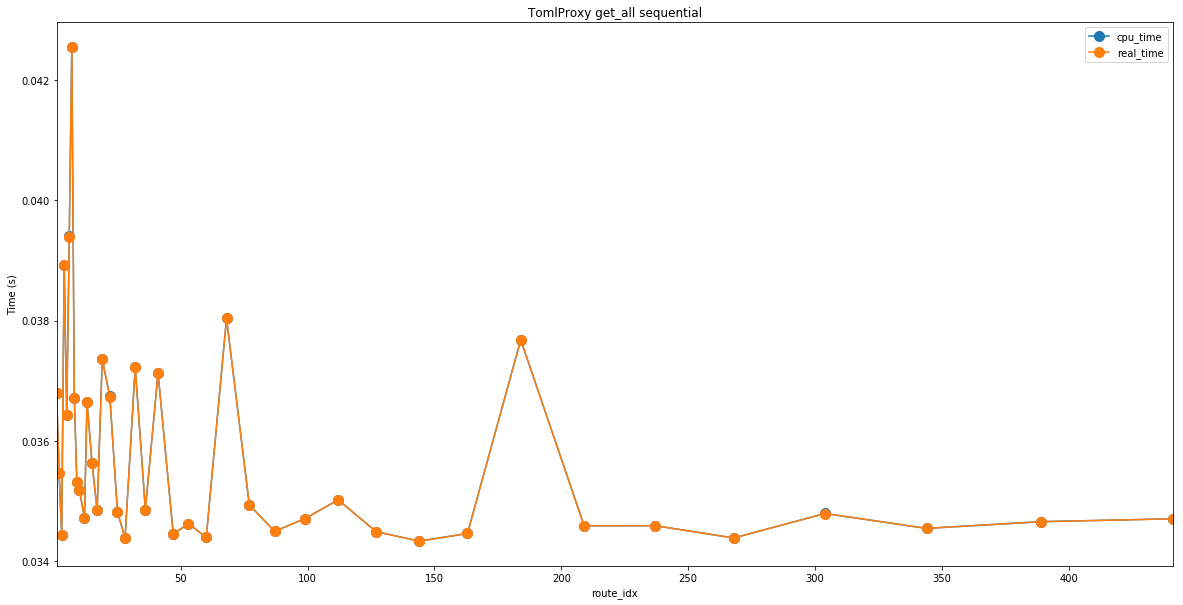

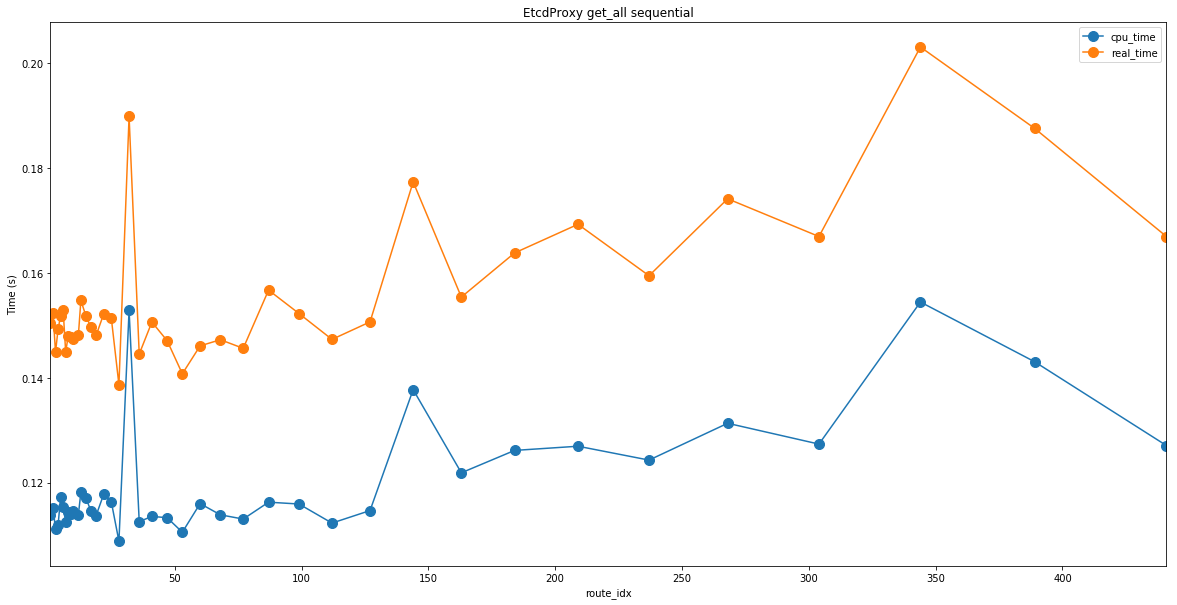

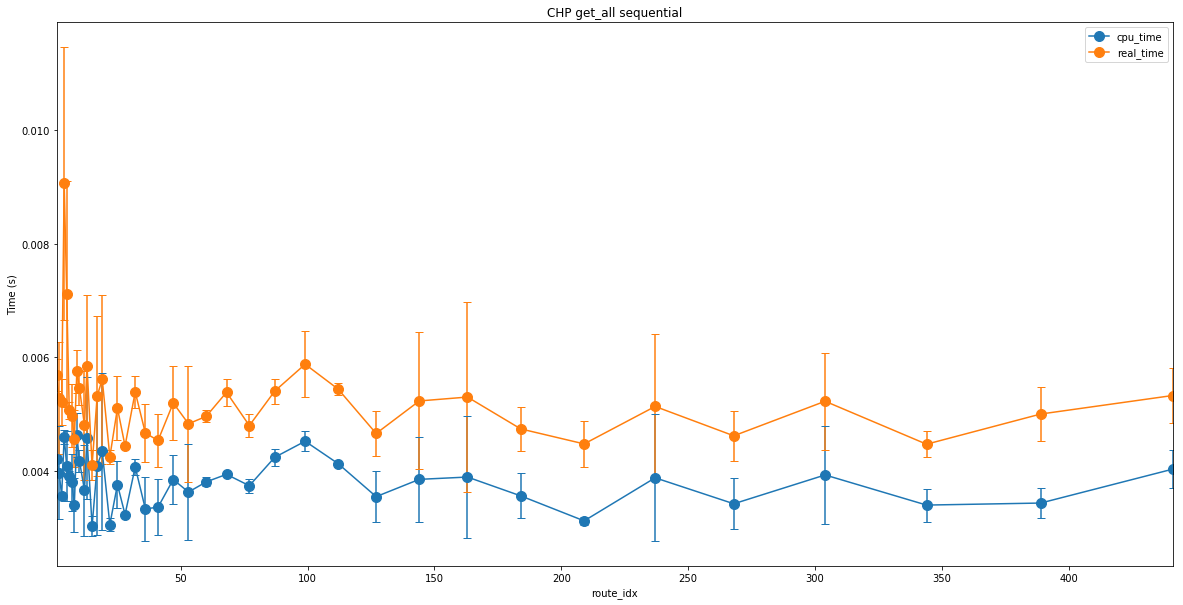

In [37]:
fig, ax = plt.subplots()
plot_proxy_method_perf(ax, proxies_df_seq, "TomlProxy", "get_all", "sequential")
plt.gca().set_ylabel("Time (s)")

fig, ax = plt.subplots()
plot_proxy_method_perf(ax, proxies_df_seq, "EtcdProxy", "get_all", "sequential")
plt.gca().set_ylabel("Time (s)")

fig, ax = plt.subplots()
plot_proxy_method_perf(ax, proxies_df_seq, "CHP", "get_all", "sequential")
plt.gca().set_ylabel("Time (s)")

Text(0, 0.5, 'CPU Time (s)')

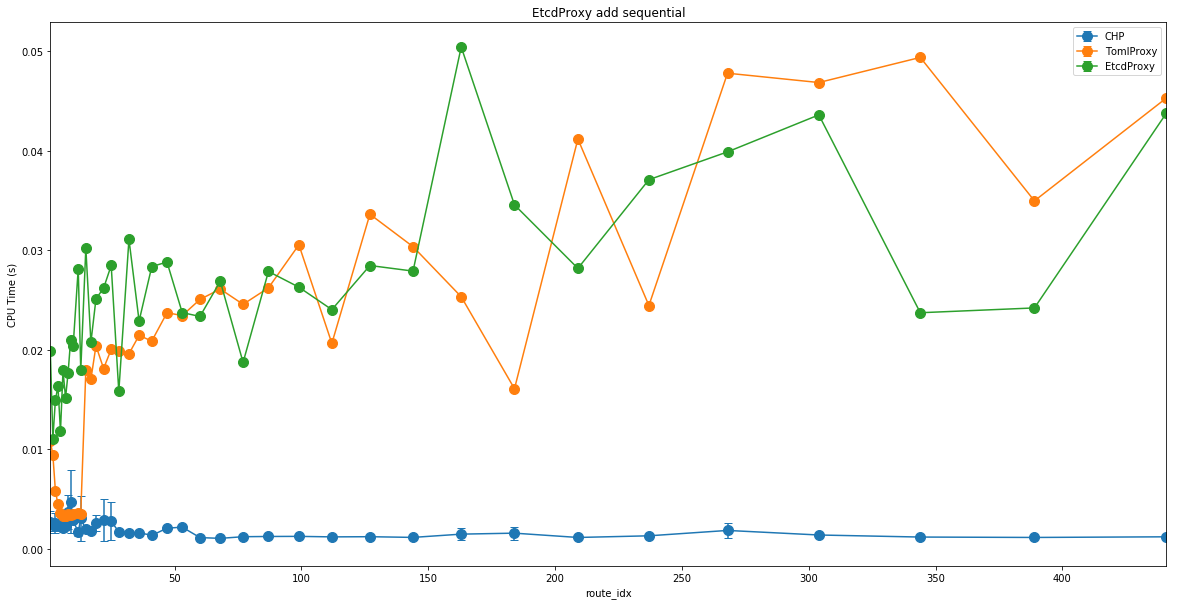

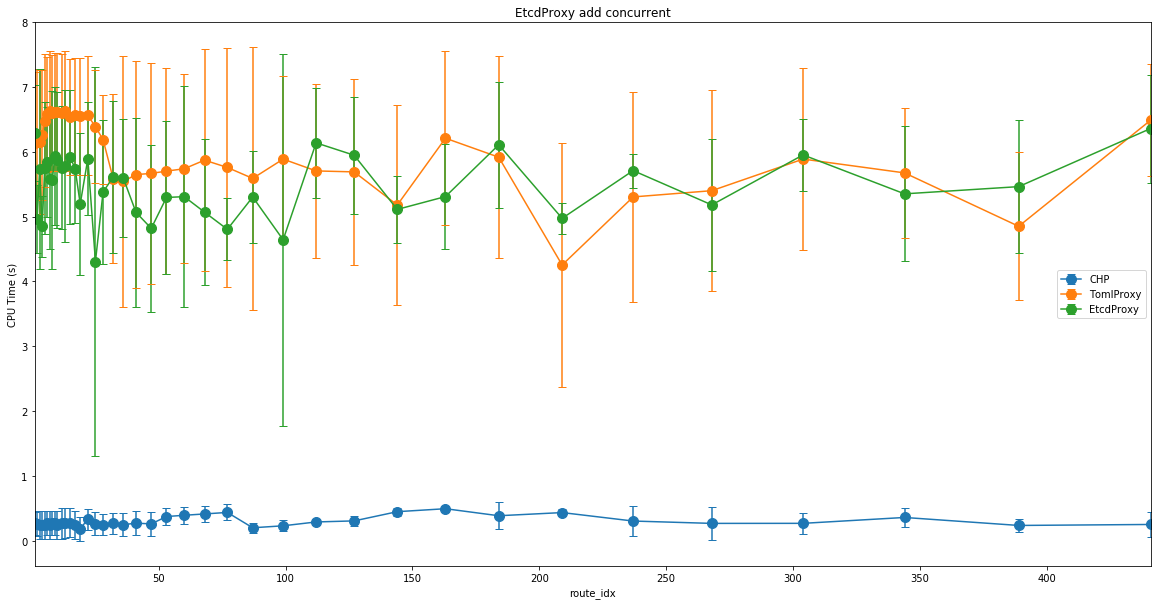

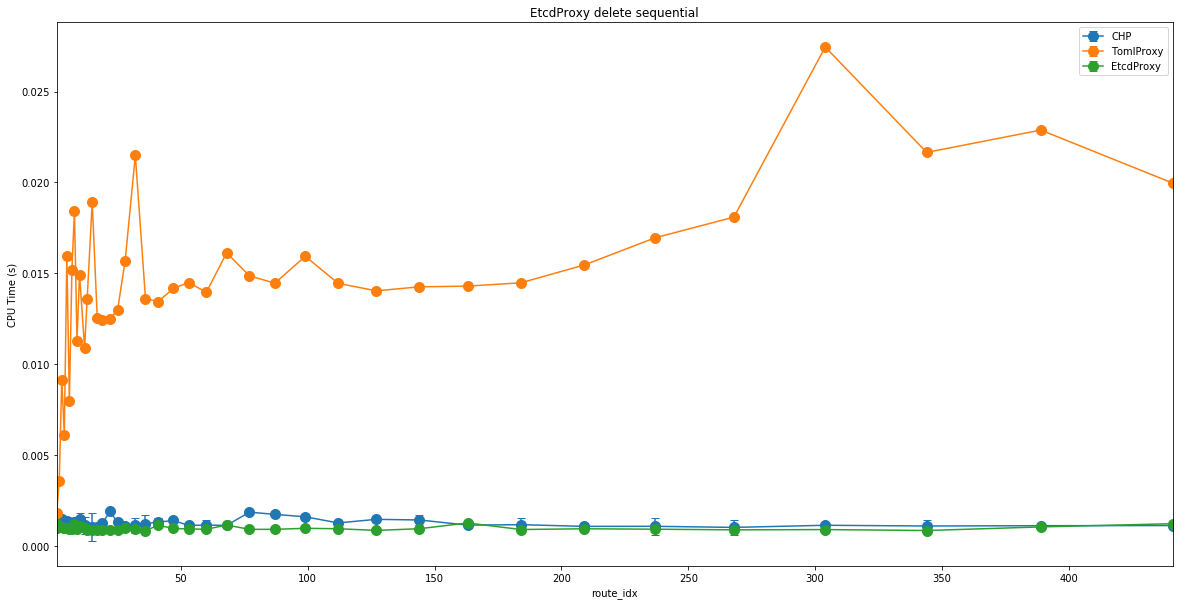

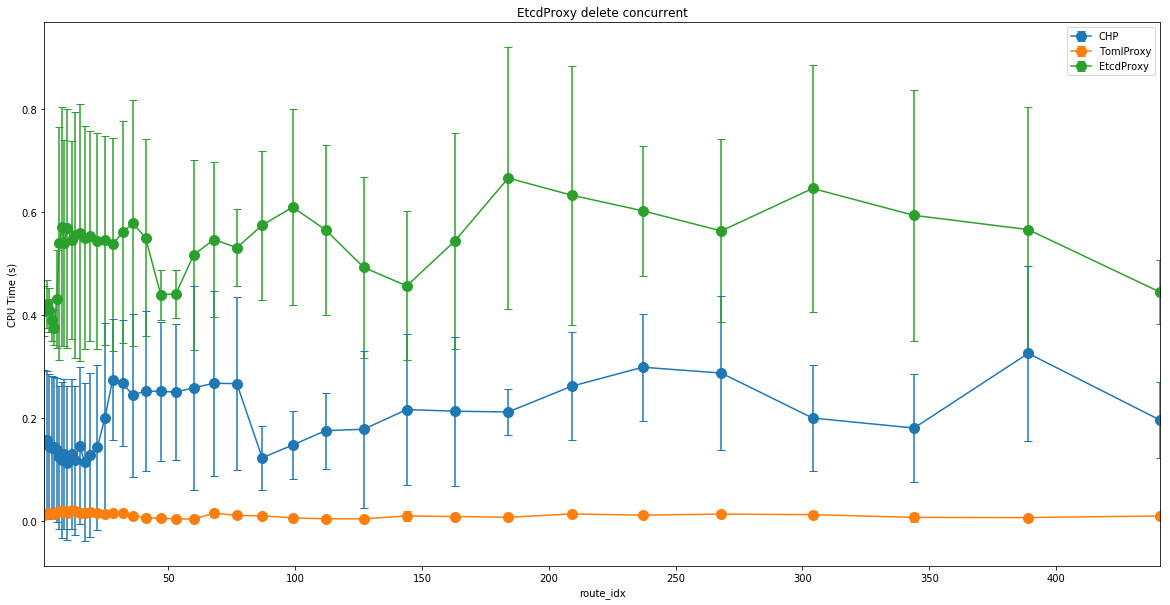

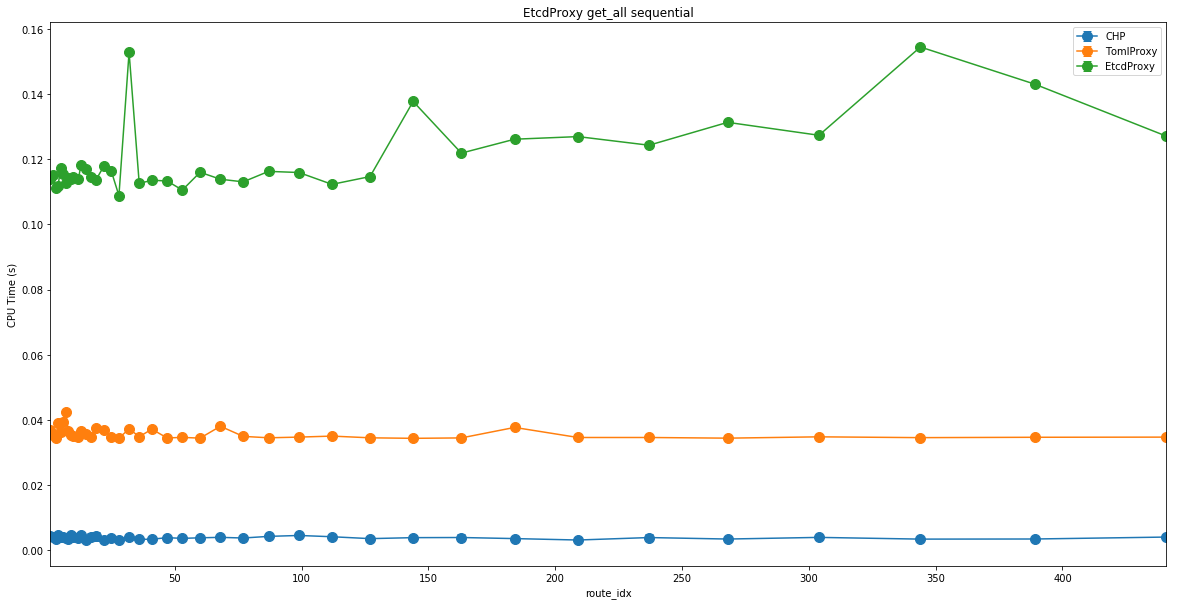

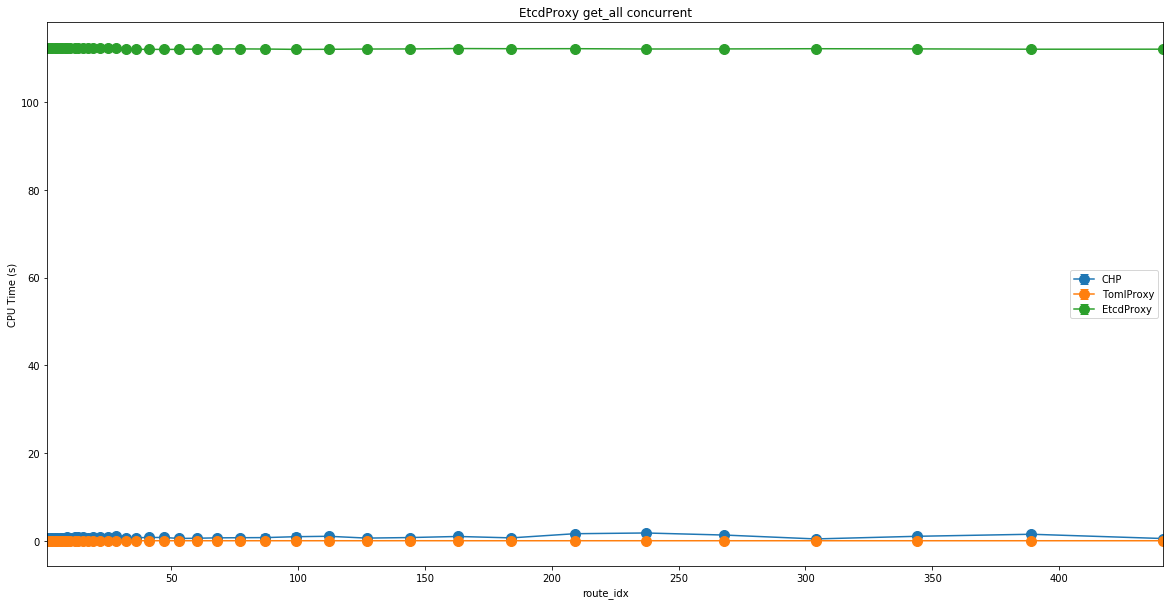

In [46]:
#ADD
%matplotlib inline
fig, ax = plt.subplots()
plot_proxy_method_perf(ax, proxies_df_seq, "CHP", "add", "sequential", "cpu_time", "blue")
plot_proxy_method_perf(ax, proxies_df_seq, "TomlProxy", "add", "sequential", "cpu_time", "orange")
plot_proxy_method_perf(ax, proxies_df_seq, "EtcdProxy", "add", "sequential", "cpu_time", "green")
plt.gca().legend(('CHP','TomlProxy', 'EtcdProxy'))
plt.gca().set_ylabel("CPU Time (s)")

fig, ax = plt.subplots()
plot_proxy_method_perf(ax, proxies_df_concurrent, "CHP", "add", "concurrent", "cpu_time", "blue")
plot_proxy_method_perf(ax, proxies_df_concurrent, "TomlProxy", "add", "concurrent", "cpu_time", "orange")
plot_proxy_method_perf(ax, proxies_df_concurrent, "EtcdProxy", "add", "concurrent", "cpu_time", "green")
plt.gca().legend(('CHP','TomlProxy', 'EtcdProxy'))
plt.gca().set_ylabel("CPU Time (s)")

#DELETE
fig, ax = plt.subplots()
plot_proxy_method_perf(ax, proxies_df_seq, "CHP", "delete", "sequential", "cpu_time", "blue")
plot_proxy_method_perf(ax, proxies_df_seq, "TomlProxy", "delete", "sequential", "cpu_time", "orange")
plot_proxy_method_perf(ax, proxies_df_seq, "EtcdProxy", "delete", "sequential", "cpu_time", "green")
plt.gca().legend(('CHP','TomlProxy', 'EtcdProxy'))
plt.gca().set_ylabel("CPU Time (s)")

fig, ax = plt.subplots()
plot_proxy_method_perf(ax, proxies_df_concurrent, "CHP", "delete", "concurrent", "cpu_time", "blue")
plot_proxy_method_perf(ax, proxies_df_concurrent, "TomlProxy", "delete", "concurrent", "cpu_time", "orange")
plot_proxy_method_perf(ax, proxies_df_concurrent, "EtcdProxy", "delete", "concurrent", "cpu_time", "green")
plt.gca().legend(('CHP','TomlProxy', 'EtcdProxy'))
plt.gca().set_ylabel("CPU Time (s)")

#Get all
fig, ax = plt.subplots()
plot_proxy_method_perf(ax, proxies_df_seq, "CHP", "get_all", "sequential", "cpu_time", "blue")
plot_proxy_method_perf(ax, proxies_df_seq, "TomlProxy", "get_all", "sequential", "cpu_time", "orange")
plot_proxy_method_perf(ax, proxies_df_seq, "EtcdProxy", "get_all", "sequential", "cpu_time", "green")
plt.gca().legend(('CHP','TomlProxy', 'EtcdProxy'))
plt.gca().set_ylabel("CPU Time (s)")

fig, ax = plt.subplots()
plot_proxy_method_perf(ax, proxies_df_concurrent, "CHP", "get_all", "concurrent", "cpu_time", "blue")
plot_proxy_method_perf(ax, proxies_df_concurrent, "TomlProxy", "get_all", "concurrent", "cpu_time", "orange")
plot_proxy_method_perf(ax, proxies_df_concurrent, "EtcdProxy", "get_all", "concurrent", "cpu_time", "green")
plt.gca().legend(('CHP','TomlProxy', 'EtcdProxy'))
plt.gca().set_ylabel("CPU Time (s)")

# Throughput

1000 *small/large (1MB/10MB) http/ws* requests are sent to the proxy:
        - sequentially
        - max 2 concurrent
        - max 3 concurrent
        ...
        - max 9 concurrent
    The time taken to make these requests is measured and
    the throughput is computed as the number of requests that can be served in a second.

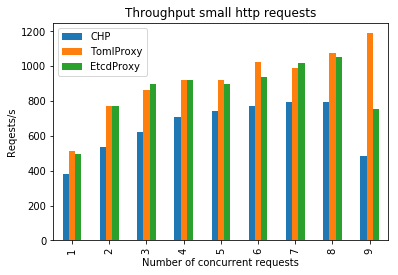

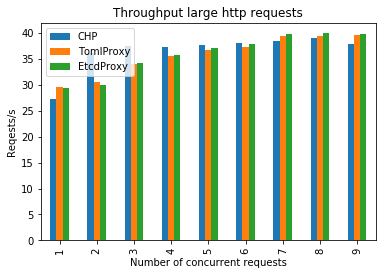

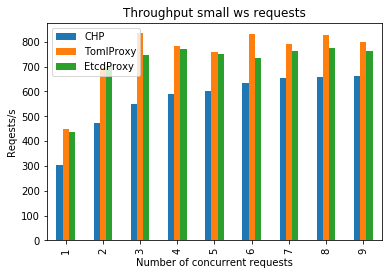

In [39]:
http_throughput_small = pd.read_csv('~/results/http_throughput_small.csv')
http_throughput_large = pd.read_csv('~/results/http_throughput_large.csv')
ws_throughput = pd.read_csv('~/results/ws_throughput.csv')
def plot_throughput(df, proto, size, req_number, bar_plot):
    df2 = df.T[1:]
    df2.columns=["CHP", "TomlProxy", "EtcdProxy"]
    if bar_plot:
        df2.plot(kind="bar")
    else:
        df2.plot()
    plt.ylabel("Reqests/s")
    plt.xlabel("Number of concurrent requests")
    plt.title(f"Throughput {size} {proto} requests")

plot_throughput(http_throughput_small, "http", "small", 1000, True)
plot_throughput(http_throughput_large, "http", "large", 100, True)
plot_throughput(ws_throughput, "ws", "small", 1000, True)

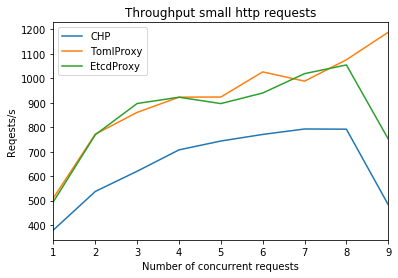

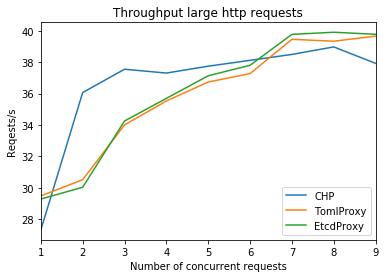

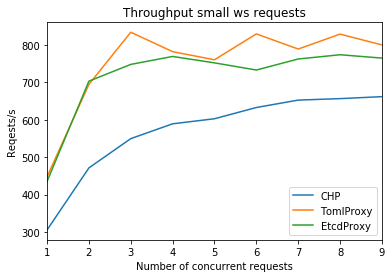

In [40]:
plot_throughput(http_throughput_small, "http", "small", 1000, False)
plot_throughput(http_throughput_large, "http", "large", 100, False)
plot_throughput(ws_throughput, "ws", "small", 1000, False)